# **This notebook will be mainly used for the capstone project**

## Importing packages

In [1]:
import pandas as pd
import numpy as np
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [2]:
from matplotlib import pyplot as plt
import datetime
from scipy import stats
from warnings import filterwarnings
filterwarnings('ignore')

## Reading and cleaning of data

In [3]:
data = pd.read_csv('Data-Collisions.csv')
data.drop(columns = ['SEVERITYCODE.1'], inplace=True)

In [4]:
data.SEVERITYCODE = data.SEVERITYCODE.astype(str)

In [5]:
data = data[['SEVERITYCODE', 'ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'UNDERINFL', 'WEATHER', 'ROADCOND']]
data.dropna(inplace=True)
data = data[data.SDOT_COLCODE != 0]
data = data[data.JUNCTIONTYPE != 'Unknown']
data = data[data.WEATHER != 'Unknown']
data = data[data.ROADCOND != 'Unknown']

In [6]:
data['has_time_info'] = data.INCDTTM.apply(lambda x: 'No' if len(x) <=12 else 'Yes')
data = data[data.has_time_info == 'Yes']
data.shape

(145886, 14)

In [7]:
data.UNDERINFL = data.UNDERINFL.apply(lambda x: 0 if x == 'N' else 1 if x == 'Y' else x)
data.UNDERINFL = data.UNDERINFL.astype(str)

## A little feature engineering

### Here we categorize the time of accident into 4 time buckets, which seems like a sensible thing to do

In [8]:
from datetime import datetime
data.INCDTTM = data.INCDTTM.apply(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'))
data['hourofday'] = data.INCDTTM.apply(lambda x: x.hour)

In [9]:
data['PERIOD'] = data.hourofday.apply(lambda x: 'midnight to 6am' if x < 6 else '6am to 12noon' if x < 12 else '12noon to 6pm' if x < 18 else '6pm to midnight')

### Here we categorize the collision codes into 3 classes differentiated by the striking vehicle, which looks to be exactly how the collision codes were derived, according to the metadata online
#### ie. if a pedalcycle struck into the side of a car, then this accident's class would be 'Pedalcycle'

In [10]:
data['STRIKER'] = data.SDOT_COLCODE.apply(lambda x: 'Driven vehicle' if x < 30 else 'Driverless vehicle' if x < 50 else 'Pedalcyclist')

## Quick univariate statistical testing of correlation/association of features with SEVERITYCODE

In [11]:
Features = data[['ADDRTYPE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'PERIOD', 'JUNCTIONTYPE', 'STRIKER', 'UNDERINFL', 'WEATHER', 'ROADCOND']]

In [12]:
feature_testing_df = pd.DataFrame({'Variable': Features.columns, 'DataType': Features.dtypes.to_list()})
feature_testing_df['StatisticalTest'] = feature_testing_df.DataType.apply(lambda x: 'Chi-squared test of independence' if x == 'object' else 'Wilcoxon rank sum test')
feature_testing_df['Pvalue'] = 0.0
feature_testing_df

,Variable,DataType,StatisticalTest,Pvalue
0,ADDRTYPE,object,Chi-squared test of indepence,0.0
1,COLLISIONTYPE,object,Chi-squared test of indepence,0.0
2,PERSONCOUNT,int64,Wilcoxon rank sum test,0.0
3,PEDCOUNT,int64,Wilcoxon rank sum test,0.0
4,PEDCYLCOUNT,int64,Wilcoxon rank sum test,0.0
5,VEHCOUNT,int64,Wilcoxon rank sum test,0.0
6,PERIOD,object,Chi-squared test of indepence,0.0
7,JUNCTIONTYPE,object,Chi-squared test of indepence,0.0
8,STRIKER,object,Chi-squared test of indepence,0.0
9,UNDERINFL,object,Chi-squared test of indepence,0.0


In [13]:
for index, datatype in enumerate(feature_testing_df.DataType):
    variable = feature_testing_df.Variable[index]
    if datatype == 'object':
        contingency = pd.crosstab(data.SEVERITYCODE, data[variable])
        feature_testing_df.Pvalue[index] = stats.chi2_contingency(contingency)[1]
    else:
        feature_testing_df.Pvalue[index] = stats.ranksums(data[variable][data.SEVERITYCODE=='1'], data[variable][data.SEVERITYCODE=='2'])[1]
feature_testing_df

,Variable,DataType,StatisticalTest,Pvalue
0,ADDRTYPE,object,Chi-squared test of indepence,0.000000e+00
1,COLLISIONTYPE,object,Chi-squared test of indepence,0.000000e+00
2,PERSONCOUNT,int64,Wilcoxon rank sum test,0.000000e+00
3,PEDCOUNT,int64,Wilcoxon rank sum test,1.001245e-223
4,PEDCYLCOUNT,int64,Wilcoxon rank sum test,2.768094e-137
5,VEHCOUNT,int64,Wilcoxon rank sum test,3.339624e-232
6,PERIOD,object,Chi-squared test of indepence,7.601647e-71
7,JUNCTIONTYPE,object,Chi-squared test of indepence,0.000000e+00
8,STRIKER,object,Chi-squared test of indepence,0.000000e+00
9,UNDERINFL,object,Chi-squared test of indepence,8.299194e-31


## Preprocessing and dummy coding for categorical features

In [14]:
X = Features[['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT']]
X = pd.concat([X, pd.get_dummies(Features[['ADDRTYPE', 'COLLISIONTYPE', 'PERIOD', 'JUNCTIONTYPE', 'STRIKER', 'WEATHER', 'ROADCOND']]), Features.UNDERINFL.astype(int)], axis = 1)
X.drop(['ADDRTYPE_Block', 'COLLISIONTYPE_Angles', 'PERIOD_12noon to 6pm', 'JUNCTIONTYPE_Mid-Block (not related to intersection)', 'STRIKER_Driven vehicle', 'WEATHER_Clear', 'ROADCOND_Dry'], axis = 1, inplace = True)
X.head()

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,ADDRTYPE_Alley,ADDRTYPE_Intersection,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,...,WEATHER_Sleet/Hail/Freezing Rain,WEATHER_Snowing,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Other,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,UNDERINFL
0,2,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,4,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,3,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
y = data['SEVERITYCODE']

## Train test split for machine learning

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [17]:
X_train, X_validation_test, y_train, y_validation_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [18]:
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_test, y_validation_test, test_size=0.5, random_state=4)

In [19]:
print(X_train.shape, X_validation.shape, X_test.shape)

(102120, 42) (21883, 42) (21883, 42)


### Checking that distribution is similar amongst train, validation and test sets

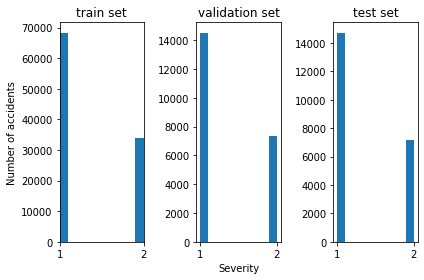

In [39]:
fig, ax = plt.subplots(1,3, tight_layout=True)
ax[0].hist(y_train)
ax[0].set_xlim(['1', '2'])
ax[0].set_title('train set')
ax[0].set_ylabel('Number of accidents')
ax[1].hist(y_validation)
ax[1].set_title('validation set')
ax[1].set_xlabel('Severity')
ax[2].hist(y_test)
ax[2].set_title('test set')
plt.savefig('train_validation_test_splits.png')
plt.show()

## Scaling features

In [21]:
from sklearn import preprocessing
X_train_scaled = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_validation_scaled = preprocessing.StandardScaler().fit(X_train).transform(X_validation)

## Support Vector Machine

In [22]:
from sklearn import svm

In [23]:
df_scores = pd.DataFrame({'C': [0.001, 0.01, 0.05, 0.10] + list(np.arange(0.20, 1.10, step=0.10)), 'jaccard index': float(0), 'f1 score': float(0)})

In [24]:
for index in df_scores.index:
    SVM = svm.LinearSVC(C=df_scores.C[index], dual=False)
    SVM.fit(X_train_scaled, y_train)
    yhat = SVM.predict(X_validation_scaled)
    df_scores['jaccard index'][index] = jaccard_similarity_score(y_validation, yhat)
    df_scores['f1 score'][index] = f1_score(y_validation, yhat, average='weighted')

C1 = df_scores.C[df_scores['f1 score'] == df_scores['f1 score'].max()].values[0]

print(df_scores)
print('Based on F1 Score, the best value for C is', C1, 'with a F1 Score of', df_scores['f1 score'].max())

        C  jaccard index  f1 score
0   0.001       0.727734  0.680328
1   0.010       0.727871  0.680506
2   0.050       0.727871  0.680506
3   0.100       0.727825  0.680470
4   0.200       0.727780  0.680399
5   0.300       0.727780  0.680399
6   0.400       0.727780  0.680399
7   0.500       0.727780  0.680399
8   0.600       0.727780  0.680399
9   0.700       0.727780  0.680399
10  0.800       0.727780  0.680399
11  0.900       0.727780  0.680399
12  1.000       0.727780  0.680399
Based on F1 Score, the best value for C is 0.01 with a F1 Score of 0.680506379515327


## Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
df_scores = pd.DataFrame({'C': [0.01, 0.05, 0.10] + list(np.arange(0.20, 1.10, step=0.10)), 'jaccard index': float(0), 'f1 score': float(0)})

In [27]:
for index, value in enumerate(df_scores.C):
    LR = LogisticRegression(C = value, solver='liblinear').fit(X_train_scaled,y_train)
    yhat = LR.predict(X_validation_scaled)
    df_scores['jaccard index'][index] = jaccard_similarity_score(y_validation, yhat)
    df_scores['f1 score'][index] = f1_score(y_validation, yhat, average='weighted')

C2 = df_scores.C[df_scores['f1 score'] == df_scores['f1 score'].max()].values[0]
print(df_scores)
print('Based on F1 Score, the best value for C is', C2, 'with a F1 Score of', df_scores['f1 score'].max())

       C  jaccard index  f1 score
0   0.01       0.727414  0.686451
1   0.05       0.727962  0.687082
2   0.10       0.728008  0.687181
3   0.20       0.728008  0.687181
4   0.30       0.728008  0.687181
5   0.40       0.728008  0.687181
6   0.50       0.727962  0.687144
7   0.60       0.727962  0.687144
8   0.70       0.727962  0.687144
9   0.80       0.727962  0.687144
10  0.90       0.727962  0.687144
11  1.00       0.727962  0.687144
Based on F1 Score, the best value for C is 0.1 with a F1 Score of 0.6871809615548027


## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
df_scores = pd.DataFrame({'min_samples_leaf': list(np.arange(1, 11, step=1)), 'jaccard index': float(0), 'f1 score': float(0)})

In [30]:
for index, value in enumerate(df_scores.min_samples_leaf):
    RFC = RandomForestClassifier(min_samples_leaf = value)
    RFC.fit(X_train_scaled, y_train)
    yhat = RFC.predict(X_validation_scaled)
    df_scores['jaccard index'][index] = jaccard_similarity_score(y_validation, yhat)
    df_scores['f1 score'][index] = f1_score(y_validation, yhat, average='weighted')

N = df_scores.min_samples_leaf[df_scores['f1 score'] == df_scores['f1 score'].max()].values[0]
print(df_scores)
print('Based on F1 Score, the best value for min_samples_leaf is', N, 'with a F1 Score of', df_scores['f1 score'].max())

   min_samples_leaf  jaccard index  f1 score
0                 1       0.720285  0.691797
1                 2       0.728831  0.691710
2                 3       0.729333  0.689997
3                 4       0.729562  0.687947
4                 5       0.730841  0.688168
5                 6       0.730476  0.688596
6                 7       0.731115  0.688168
7                 8       0.730430  0.685807
8                 9       0.729973  0.686603
9                10       0.729516  0.685783
Based on F1 Score, the best value for min_samples_leaf is 1 with a F1 Score of 0.6917972510881176


## Evaluating on test set

In [31]:
X_finaltrain = pd.concat([X_train, X_validation])

(124003, 42)

In [32]:
y_finaltrain = pd.concat([y_train, y_validation])

124003

In [33]:
X_test_scaled = preprocessing.StandardScaler().fit(X_finaltrain).transform(X_test)
X_finaltrain_scaled = preprocessing.StandardScaler().fit(X_finaltrain).transform(X_finaltrain)

In [34]:
SVM = svm.LinearSVC(C = C1, dual=False).fit(X_finaltrain_scaled,y_finaltrain)
yhat = SVM.predict(X_test_scaled)
print('F1 score for Support Vector Classifier is', f1_score(y_test, yhat, average='weighted'))

Jaccard index for Support Vector Classifier is 0.7334003564410729
F1 score for Support Vector Classifier is 0.6867632038709867


In [35]:
LR = LogisticRegression(C = C2, solver='liblinear').fit(X_finaltrain_scaled,y_finaltrain)
yhat = LR.predict(X_test_scaled)
print('F1 score for Logistic Regression is', f1_score(y_test, yhat, average='weighted'))

Jaccard index for Logistic Regression is 0.7331261710003198
F1 score for Logistic Regression is 0.6943347699966038


In [36]:
RFC = RandomForestClassifier(min_samples_leaf = N).fit(X_finaltrain_scaled,y_finaltrain)
yhat = RFC.predict(X_test_scaled)
print('F1 score for Random Forest Classifier is', f1_score(y_test, yhat, average='weighted'))

Jaccard index for Random Forest Classifier is 0.7256774665265274
F1 score for Random Forest Classifier is 0.6955057296244938


In [41]:
print('Simply predicting SEVERITYCODE = 1 for all accidents in the test set would yield an F1 score of', f1_score(y_test, ['1'] * len(y_test), average='weighted'))

Simply predicting SEVERITYCODE = 1 for all accidents in the test set would yield an F1 score of 0.5405024197073691
